## WEEK 3: Scaling of matrix-matrix multiplication
### Quantum Information and Computing (2021/22)

### Samuele Piccinelli
#### 23 November 2021

#### 1. Import libraries and useful dependencies

In [1]:
import numpy as np
import subprocess as sp

# plot settings
import matplotlib
import matplotlib.pyplot as plt
plt.rc('font',**{'size':16, 'family':'serif','serif':['Computer Modern Roman']})
plt.rc('text', usetex=True)
plt.rc('mathtext', **{'fontset':'cm'})
plt.rc('xtick', labelsize = 16)
plt.rc('ytick', labelsize = 16)

In [2]:
# returns optimal figsize to include in LaTeX document
def latex_figsize(wf=0.5, hf=(5.**0.5-1.0)/2.0, columnwidth=469.7550):
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27
    fig_width = fig_width_pt*inches_per_pt
    fig_height = fig_width*hf
    return [fig_width, fig_height]

#### 2. Launch FORTRAN script and get terminal output

In [3]:
# declare grid of values
N_min  = 50
N_max  = 2000

# default is 50 step
Ns = np.logspace(np.log10(N_min), np.log10(N_max), num=25, dtype=int)

N_times = 5

In [4]:
# compile and get executable
src = 'performance.f90'
exe = 'performance.out'
sp.run(['gfortran', 'checkpoint.f90', 'debug_matmul.f90', 'routine.f90', src, '-o', exe])

CompletedProcess(args=['gfortran', 'checkpoint.f90', 'debug_matmul.f90', 'routine.f90', 'performance.f90', '-o', 'performance.out'], returncode=0)

In [5]:
# get terminal output: https://bit.ly/30Fwj0e
def get_output(N):
    output = sp.Popen( [('./' + exe), str(N)], stdout=sp.PIPE ).communicate()[0]
    times = output.decode('utf-8').split()
    return np.array([float(time) for time in times])

In [6]:
# declare empty vectors to host results
by_row = np.zeros(len(Ns))
by_col = np.zeros(len(Ns))
matmul = np.zeros(len(Ns))

std_by_row = np.zeros(len(Ns))
std_by_col = np.zeros(len(Ns))
std_matmul = np.zeros(len(Ns))

In [7]:
for ii, n in enumerate(Ns):
    print('Running "' + exe + '" for N = ' + str(n))
    res = np.zeros((3, N_times))
    
    for jj in range(N_times):
        res[:,jj] = get_output(n)
        
    # compute and store mean
    by_row[ii] = np.mean(res[0,:])
    by_col[ii] = np.mean(res[1,:])
    matmul[ii] = np.mean(res[2,:])
    # compute and store standard deviation
    std_by_row[ii] = np.std(res[0,:]) / np.sqrt(N_times)
    std_by_col[ii] = np.std(res[1,:]) / np.sqrt(N_times)
    std_matmul[ii] = np.std(res[2,:]) / np.sqrt(N_times)

Running "performance.out" for N = 49
Running "performance.out" for N = 58
Running "performance.out" for N = 67
Running "performance.out" for N = 79
Running "performance.out" for N = 92
Running "performance.out" for N = 107
Running "performance.out" for N = 125
Running "performance.out" for N = 146
Running "performance.out" for N = 170
Running "performance.out" for N = 199
Running "performance.out" for N = 232
Running "performance.out" for N = 271
Running "performance.out" for N = 316
Running "performance.out" for N = 368
Running "performance.out" for N = 430
Running "performance.out" for N = 501
Running "performance.out" for N = 584
Running "performance.out" for N = 681
Running "performance.out" for N = 795
Running "performance.out" for N = 927
Running "performance.out" for N = 1081
Running "performance.out" for N = 1261
Running "performance.out" for N = 1470
Running "performance.out" for N = 1715
Running "performance.out" for N = 2000


#### 3. Write results on file

In [8]:
# concatenate results
by_row = np.column_stack((Ns, by_row, std_by_row))
by_col = np.column_stack((Ns, by_col, std_by_col))
matmul = np.column_stack((Ns, matmul, std_matmul))

In [9]:
# write on file
np.savetxt('ex1/by_row.dat', by_row)
np.savetxt('ex1/by_col.dat', by_col)
np.savetxt('ex1/matmul.dat', matmul)

#### 4. Load and plot results

In [4]:
by_row = np.loadtxt('ex1/by_row.dat')
by_col = np.loadtxt('ex1/by_col.dat')
matmul = np.loadtxt('ex1/matmul.dat')

In [5]:
from scipy.optimize import curve_fit ## sistema

def func(x, a, b):
    return a * x + b

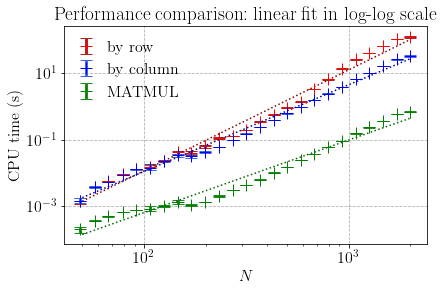

In [9]:
fig, ax = plt.subplots(figsize=latex_figsize(wf=1.))

ax.errorbar(by_row[:,0], by_row[:,1], yerr=by_row[:,2], fmt='+r', ecolor='firebrick',\
            elinewidth=3, markersize=12, mew=1, capsize=6, label='by row')

ax.errorbar(by_col[:,0], by_col[:,1], yerr=by_col[:,2], fmt='+b', ecolor='royalblue',\
            elinewidth=3, markersize=12, mew=1, capsize=6, label='by column')

ax.errorbar(matmul[:,0], matmul[:,1], yerr=matmul[:,2], fmt='+g', ecolor='forestgreen',\
            elinewidth=3, markersize=12, mew=1, capsize=6, label='MATMUL')

alpha = np.linspace(N_min, N_max, 1000)

popt_by_row, pcov_by_row = curve_fit(func, np.log10(by_row[:,0]), np.log10(by_row[:,1]))
popt_by_col, pcov_by_col = curve_fit(func, np.log10(by_col[:,0]), np.log10(by_col[:,1]))
popt_matmul, pcov_matmul = curve_fit(func, np.log10(matmul[:,0]), np.log10(matmul[:,1]))

plt.plot(alpha, 10**(func(np.log10(alpha), *popt_by_row)), ':', color='darkred') #label='$\log(y)=3.04\log(x)-8.0$'
plt.plot(alpha, 10**(func(np.log10(alpha), *popt_by_col)), ':', color='darkblue') #label='$\log(y)=2.61\log(x)-7.2$'
plt.plot(alpha, 10**(func(np.log10(alpha), *popt_matmul)), ':', color='darkgreen') #label='$\log(y)=2.19\log(x)-7.6$'

ax.set_title('Performance comparison:\\ linear fit in $\log$-$\log$ scale')
ax.set_ylabel('CPU time (s)')
ax.set_xlabel('$N$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, which='major', ls='--')
ax.legend(handlelength=1, frameon=False)

plt.savefig('by_fit.pdf', bbox_inches='tight', dpi=150)
plt.show()

In [15]:
print('fit by row: a=%5.3f, b=%5.3f' % tuple(popt_by_row))
print('fit by row: a=%5.3f, b=%5.3f' % tuple(np.sqrt(np.diag(pcov_by_row))))

fit by row: a=3.035, b=-8.002
fit by row: a=0.078, b=0.198


In [16]:
print('fit by col: a=%5.3f, b=%5.3f' % tuple(popt_by_col))
print('fit by col: a=%5.3f, b=%5.3f' % tuple(np.sqrt(np.diag(pcov_by_col))))

fit by col: a=2.608, b=-7.169
fit by col: a=0.052, b=0.133


In [17]:
print('fit matmul: a=%5.3f, b=%5.3f' % tuple(popt_matmul))
print('fit matmul: a=%5.3f, b=%5.3f' % tuple(np.sqrt(np.diag(pcov_matmul))))

fit matmul: a=2.185, b=-7.560
fit matmul: a=0.086, b=0.219
